In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/Addi8/Laptopshop/master/dump/reviews.json', 'reviews.json')
urllib.request.urlretrieve('https://raw.githubusercontent.com/Addi8/topic-modeling/main/vagueWords.txt', 'vagueWords.txt')
urllib.request.urlretrieve('https://raw.githubusercontent.com/Addi8/topic-modeling/main/stopwords.txt', 'stopwords.txt')


('stopwords.txt', <http.client.HTTPMessage at 0x7fa6584690a0>)

# Importing the Libraries

In [3]:
!pip install wordcloud
!pip install pandas nltk gensim pyLdavis

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/medhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/medhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/medhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Prepare Vague words List

In [5]:
from nltk.corpus import wordnet

In [6]:
def get_synonyms(ofword):
  from nltk.corpus import wordnet
  synonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      synonyms.append(l.name())

  return synonyms

In [7]:
def get_antonyms(ofword):
  from nltk.corpus import wordnet
  antonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      if l.antonyms():
          antonyms.append(l.antonyms()[0].name())

  return antonyms
  # print(set(antonyms))

In [8]:
synonyms = get_synonyms("active")
print (synonyms)

['active_agent', 'active', 'active_voice', 'active', 'active', 'active', 'active', 'combat-ready', 'fighting', 'active', 'active', 'participating', 'active', 'active', 'active', 'active', 'alive', 'active', 'active', 'active', 'dynamic', 'active', 'active', 'active']


In [9]:
# read the words to list
with open('vagueWords.txt') as vague_word_list_file:
    vague_word_list = vague_word_list_file.read().splitlines()

vague_word_set = set()

# Add the synonyms of each word
for vagueword in vague_word_list:
  for vague_word_synonym in get_synonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Add the antonyms( of each word 
for vagueword in vague_word_list:
  for vague_word_synonym in get_antonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Remove unncessary words
remove_word_list = ['adept']
for word in remove_word_list:
  if word in vague_word_set:
    vague_word_set.remove(word)

# Add words without adding synonyms
addtional_word_list = ['didnt', 'doesnt']
for word in addtional_word_list:
  vague_word_set.add(word)

vague_word_set = sorted(vague_word_set)

vague_word_list = list(vague_word_set)

print(len(vague_word_list))

# for word in vague_word_list:
#   print (word)

357


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import json
import math
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import matplotlib.colors as mcolors
from collections import Counter

# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# % matplotlib inline

# Importing the dataset

In [11]:
reviews = []
with open('reviews.json') as file:
  for line in file:
      entry = json.loads(line)
      reviews.append(entry["_source"]["review"])
#for review in reviews:
#  print(review)
len(reviews)


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


140590

# Tokenize sentences

In [12]:
from nltk.tokenize import sent_tokenize

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
sentences_set = set()
for review in reviews:
  for sentence in sent_tokenize(review):
    sentences_set.add(sentence.lower())
sentences = list(sentences_set) 

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def get_stopwords():
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stopwords = set(stopwords.words('english'))
  # read the words to list
  with open('stopwords.txt') as stop_word_list_file:
    for word in stop_word_list_file.read().splitlines():
      stopwords.add(word.lower())

  additional_words = ["hi", "ok", "am", "would", "i'm"]
  for word in additional_words:
    stopwords.add(word)
  return stopwords

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Cleaning Up The Data

In [16]:
reviews = sentences
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in reviews]
stopwords = get_stopwords()
texts = [[word for word in document.lower().split() if word not in stopwords] for document in reviews]
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /home/medhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
print (frequency['didnt'])

7915


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Processing

In [18]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA

In [19]:
NUM_TOPICS = 9
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10)
topics = ldamodel.show_topics(num_topics= NUM_TOPICS,num_words=20,formatted=False)

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Ranking

In [20]:
# Probability 
# with open('vagueWords.txt') as vague_word_list_file:
#     vague_word_list = vague_word_list_file.read().splitlines()

vague_words_in_topics = dict()
words_in_topics = dict()
for i, topic in enumerate(topics):
    vague_words_in_topics[i] = 0
    words_in_topics[i] = 0
    for x, word_tuple in enumerate(topic[1]):
      for y, vague_word in enumerate(vague_word_list):
        words_in_topics[i] = words_in_topics[i] + round(len(ldamodel.id2word)*word_tuple[1]) #Total number of words in Topic[n] (top 10)
        if vague_word in word_tuple:
          vague_words_in_topics[i] = vague_words_in_topics[i] + round(len(ldamodel.id2word)*word_tuple[1]) #Total number of Vague Words in Topic[n] (top 10)

topic_rankings = dict()
for i, (key,number_of_vague_words) in enumerate(vague_words_in_topics.items()):
  if number_of_vague_words > 0:
    topic = topics[i]
    word_tuples = topic[1]
    topic_rankings[i] = number_of_vague_words / words_in_topics[i]
  else:
    topic_rankings[i] = 0
  print("Ranking for Topic " + str(i+1) + ": "+str(topic_rankings[i]*100)+"%" + ", Vagues Words: "+str(number_of_vague_words)+", Total Words: "+str(words_in_topics[i]))


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ranking for Topic 1: 0.04138994653655454%, Vagues Words: 1687, Total Words: 4075869
Ranking for Topic 2: 0.014494424267362787%, Vagues Words: 596, Total Words: 4111926
Ranking for Topic 3: 0.013520943083875742%, Vagues Words: 710, Total Words: 5251113
Ranking for Topic 4: 0.022485470164416835%, Vagues Words: 964, Total Words: 4287213
Ranking for Topic 5: 0%, Vagues Words: 0, Total Words: 4249014
Ranking for Topic 6: 0.02333269916253558%, Vagues Words: 975, Total Words: 4178685
Ranking for Topic 7: 0.02459394108845017%, Vagues Words: 855, Total Words: 3476466
Ranking for Topic 8: 0.09519439003891517%, Vagues Words: 5968, Total Words: 6269277
Ranking for Topic 9: 0%, Vagues Words: 0, Total Words: 3622836


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


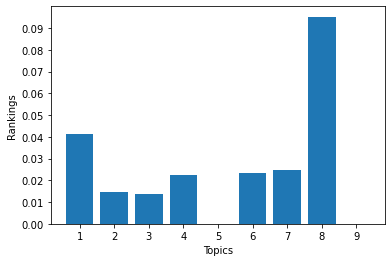

In [21]:
topic_rankings_x = [x + 1 for x in topic_rankings.keys()] # add 1 to all values
topic_rankings_y = [x * 100 for x in topic_rankings.values()] # multiply all values by 100

plt.yticks(np.arange(0, 1, .01))
plt.xticks(np.arange(0, NUM_TOPICS + 1, 1))
plt.bar(topic_rankings_x, topic_rankings_y)
plt.ylabel('Rankings')
plt.xlabel('Topics')
plt.show()

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


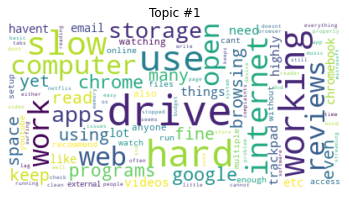

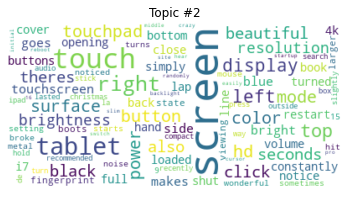

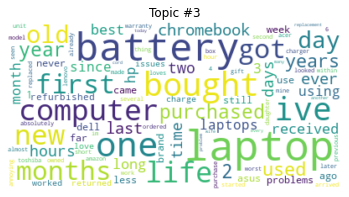

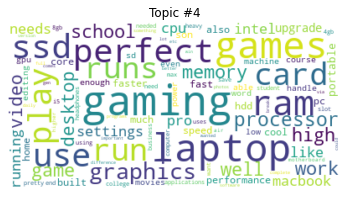

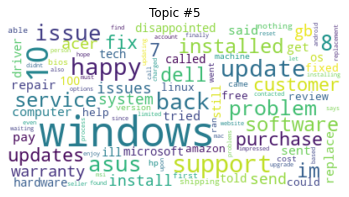

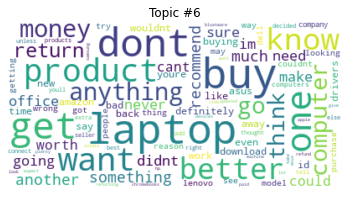

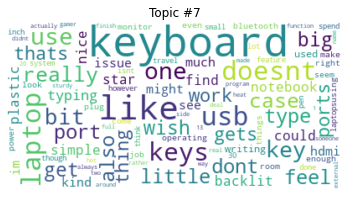

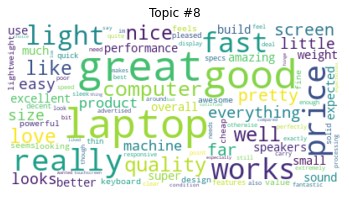

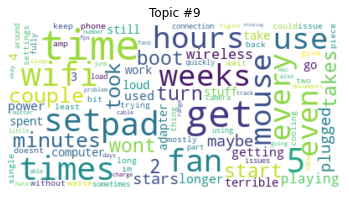

In [22]:
import matplotlib.pyplot as plt
for t in range(ldamodel.num_topics):
    plt.figure()
    plt.imshow(WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(dict(ldamodel.show_topic(t, 200))),interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.show()


/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


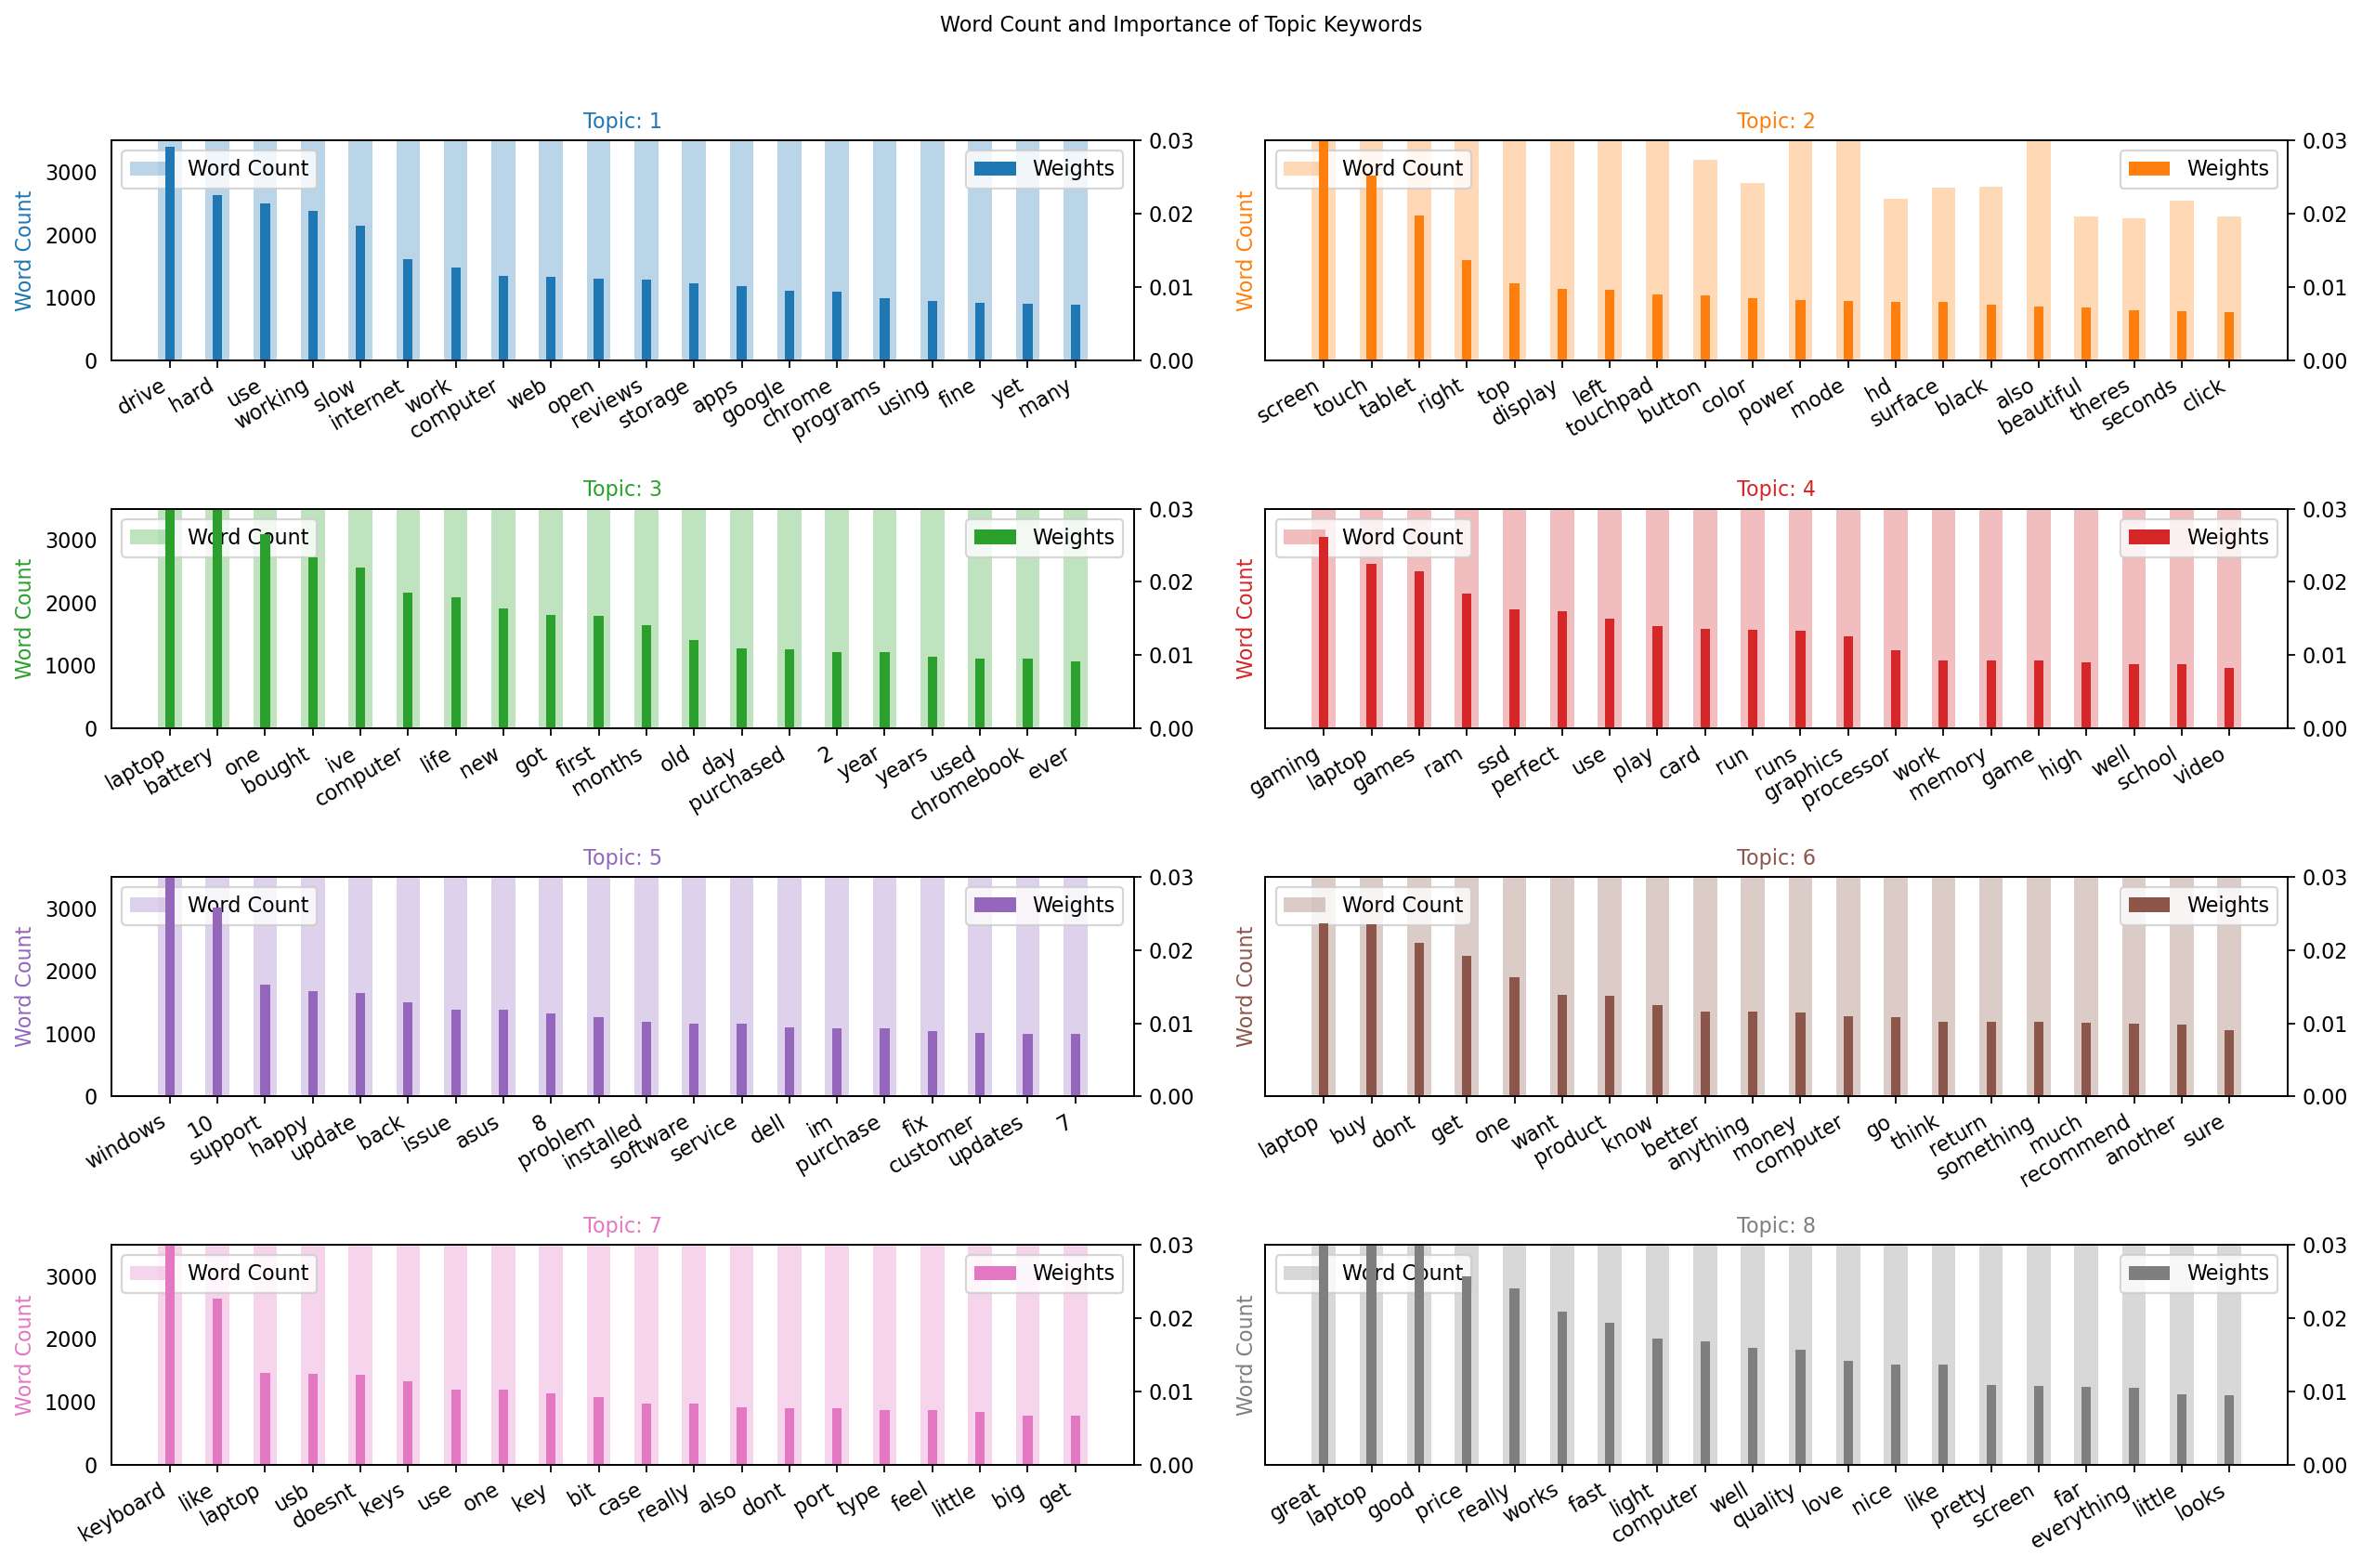

In [23]:
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4,2,figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)    
plt.show()

In [24]:
review_lengths = []
average_review_length = 0
total_length = 0
min_length = len(reviews[0])
max_length = 0
for i, review in enumerate(reviews):
  review_length = len(review)
  total_length = total_length + review_length
  review_lengths.append(review_length)
  if max_length < review_length:
    max_length = review_length
  if min_length > review_length:
    min_length = review_length

average_review_length = math.ceil(total_length/len(reviews))
print("Total Reviews: "+str(len(reviews))+ ", Average Review Length:"+ str(average_review_length)+", Minimum Length: "+str(min_length)+", Maximum Length: "+str(max_length))

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Reviews: 537053, Average Review Length:89, Minimum Length: 0, Maximum Length: 5328


In [25]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,drive,screen,laptop,gaming,windows,laptop,keyboard,great,time
1,hard,touch,battery,laptop,10,buy,like,laptop,get
2,use,tablet,one,games,support,dont,laptop,good,5
3,working,right,bought,ram,happy,get,usb,price,wifi
4,slow,top,ive,ssd,update,one,doesnt,really,times
5,internet,display,computer,perfect,back,want,keys,works,pad
6,work,left,life,use,issue,product,use,fast,set
7,computer,touchpad,new,play,asus,know,one,light,fan
8,web,button,got,card,8,better,key,computer,mouse
9,open,color,first,run,problem,anything,bit,well,hours


# Visualization

In [26]:
!pip install pyLDAvis==2.1.2

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/Addi8/topic-modeling/main/mallet-2.0.8.zip', 'mallet.zip')

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('mallet.zip', <http.client.HTTPMessage at 0x7fa5e436a5b0>)

In [29]:
import subprocess
subprocess.call(["unzip", 'mallet.zip'])

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1

In [30]:
import gensim
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = '/home/medhat/Workspace/mallet-2.0.8/bin/mallet' 
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=ldamodel.id2word)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
limit=14; start=7; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=ldamodel.id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

# Show graph

/home/medhat/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

In [46]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.046*"windows" + 0.030*"work" + 0.022*"10" + 0.017*"chromebook" + 0.016*"slow" + 0.013*"system" + 0.013*"lot" + 0.013*"software" + 0.013*"dont" + 0.013*"computer"'), (1, '0.080*"laptop" + 0.062*"great" + 0.044*"good" + 0.044*"battery" + 0.029*"fast" + 0.026*"works" + 0.023*"life" + 0.018*"hours" + 0.017*"gaming" + 0.016*"pretty"'), (2, '0.026*"time" + 0.019*"power" + 0.018*"doesnt" + 0.016*"working" + 0.013*"usb" + 0.011*"thing" + 0.011*"mouse" + 0.011*"pad" + 0.010*"wifi" + 0.010*"times"'), (3, '0.027*"drive" + 0.020*"hard" + 0.018*"games" + 0.017*"ssd" + 0.016*"ram" + 0.015*"run" + 0.014*"2" + 0.012*"card" + 0.012*"performance" + 0.011*"play"'), (4, '0.089*"laptop" + 0.067*"computer" + 0.036*"im" + 0.031*"bought" + 0.028*"ive" + 0.026*"buy" + 0.020*"price" + 0.017*"months" + 0.015*"recommend" + 0.015*"purchase"'), (5, '0.063*"screen" + 0.040*"keyboard" + 0.022*"love" + 0.021*"nice" + 0.021*"light" + 0.019*"quality" + 0.016*"touch" + 0.014*"easy" + 0.014*"bit" + 0.013*"tablet"'

In [47]:
!pip install tqdm

In [48]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                               eta=b)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ldamodel.id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [54]:
 list(np.arange(0.01, 1, 0.3))

[0.01, 0.31, 0.61, 0.9099999999999999]

Process ForkPoolWorker-143:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-144:
Process ForkPoolWorker-145:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-154:
Traceback (most recent call last):
Process ForkPoolWorker-155:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worke

Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
 

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-176:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-177:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  

Traceback (most recent call last):
Process ForkPoolWorker-187:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
 

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-198:
Traceback (most recent call last):
  File "

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-208:
Traceback (most recent call last):
Process ForkPoolWorker-209:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/py

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-219:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/

ValueError: semaphore or lock released too many times
Process ForkPoolWorker-229:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
Process ForkPoolWorker-230:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock re

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueEr

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-251:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-252:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/py

Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-262:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initar

Process ForkPoolWorker-272:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-273:
Traceback (most recent call last):
  

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-283:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-284:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_st

Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  Fil

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-305:
Traceback (most recent call last):
Process ForkPoolWorker-306:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 14
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
               
corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
                
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        print("i " + str(i))
        # iterate through number of topics
        for k in topics_range:
            print("k "  + str(k))
            # iterate through alpha values
            for a in alpha:
                print("a " + str(a))
                # iterare through beta values
                for b in beta:
                    print("b " + str(b))
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=ldamodel.id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()





  0%|          | 0/540 [00:00<?, ?it/s]Process ForkPoolWorker-308:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)


i 0
k 8
a 0.01
b 0.01


  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
Process ForkPoolWorker-309:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
Traceback (most recent call last):
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/q

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-323:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-333:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-334:
Traceback (most recent call last):
  

Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
 

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-355:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_s

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-366:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-376:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-377:
Traceback (most recent call last):
  

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-387:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
Process ForkPoolWorker-388:
  File "/home/medhat/anaconda3/lib

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-398:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    

ValueError: semaphore or lock released too many times
Process ForkPoolWorker-408:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
Process ForkPoolWorker-409:
ValueError: semaphore or lock released too many times
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-419:
ValueError: semaphore or lock released too many times
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
Process ForkPoolWorker-420:
Traceback (most recent call last):
  

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-430:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/q

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
Process ForkPoolWorker-441:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-452:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/l

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-462:
Traceback (most recent call last):
Process ForkPoolWorker-463:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiproces

ValueError: semaphore or lock released too many times
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-473:
Traceback (most recent call last):
Process ForkPoolWorker-474:
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_st

  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-484:
Process ForkPoolWorker-485:
ValueError: semaphore or lock released too many times
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, i

ValueError: semaphore or lock released too many times
Process ForkPoolWorker-494:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Process ForkPoolWorker-495:
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  

  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
    self._sem.release()
ValueError: semaphore or lock released too many times
Traceback (most recent call last):
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/medhat/anaconda3/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/medhat/anaconda3/lib/python3.8/multiprocessing/queues.py", line 98, in get
 

In [ ]:
model_results

In [ ]:
print(model_results)

In [ ]:
print("done")

In [ ]:
!pip freeze